In [2]:
import os
import re
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

def extract_averages_from_log(logfile_name):
    # Regular expressions for extracting energy and throughput values
    energy_pattern = re.compile(r"Total energy used: ([\d.]+) Joules")
    throughput_pattern = re.compile(r"mean Network throughput: ([\d.]+) \[Mb/s\]")
    
    # Lists to hold extracted values for averaging
    energy_values = []
    throughput_values = []

    with open(logfile_name, 'r') as file:
        content = file.read()
        
        # Split the content into blocks
        blocks = content.split("From Main : Total")
        
        # Process each block
        for block in blocks:
            if "400 chunks will be downloaded" in block:
                # Extract energy value
                energy_match = energy_pattern.search(block)
                if energy_match:
                    energy_values.append(float(energy_match.group(1)))
                
                # Extract throughput value
                throughput_match = throughput_pattern.search(block)
                if throughput_match:
                    throughput_values.append(float(throughput_match.group(1)))

    # Calculate averages
    avg_energy = sum(energy_values) / len(energy_values) if energy_values else 0
    avg_throughput = sum(throughput_values) / len(throughput_values) if throughput_values else 0
    
    return avg_energy, avg_throughput

# Define the directory path
directory_path = './output_logs_9-21-2023/'

# List all files in the directory
all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

data=[]
# Define the regular expression pattern
pattern = re.compile(r'P(\d+)_C(\d+)\.log')

for filename in all_files:
    filename_ = os.path.basename(filename)
    avg_energy, avg_throughput = extract_averages_from_log(filename)
    match = pattern.match(filename_)
    if match:
        number1, number2 = map(int, match.groups())
        # Instead of just creating a tuple, populate the data list
        data.append({
            "parallelism": number1,
            "concurrency": number2,
            "throughput": avg_throughput,
            "energy": avg_energy
        })

# Convert the list of dictionaries to a dataframe
df = pd.DataFrame(data)

# If you want to see the dataframe
print(df)

    parallelism  concurrency   throughput        energy
0            16            1  2459.163500   3902.366542
1             7            7  4977.605333   1692.184592
2            16            8  6577.045100   2352.367995
3            16           16  4577.574125   2522.075529
4             2           16  5688.650400   2164.288417
5             4            2  2208.667200   2771.881820
6             8            8  5874.215087   1884.476719
7            16            4  6666.292875   2511.597758
8             4            4  4266.515000   1788.968100
9             4            8  5333.115600   2174.732238
10            2            1   598.022800   7469.339027
11            1           16  4266.501100   1778.666559
12            1            1   303.660900  14377.141906
13            1            2   597.746900   7557.942499
14            1            8  2208.667900   2741.340529
15            2            4  2251.749100   2657.011295
16           16            2  4586.545600   2860

In [3]:
df = df.sort_values(by=['concurrency', 'parallelism'])
df.to_csv('log_summary_C_P_1-16.csv', index=False)
print(df)

    parallelism  concurrency   throughput        energy
12            1            1   303.660900  14377.141906
10            2            1   598.022800   7469.339027
23            4            1  1160.182700   4237.313113
25            8            1  2322.864900   2590.214500
0            16            1  2459.163500   3902.366542
13            1            2   597.746900   7557.942499
21            2            2  1173.386400   4131.792163
5             4            2  2208.667200   2771.881820
24            8            2  4266.495200   1793.478581
16           16            2  4586.545600   2860.268734
22            1            4  1166.422100   4307.985743
15            2            4  2251.749100   2657.011295
8             4            4  4266.515000   1788.968100
19            8            4  4728.720400   2795.614981
7            16            4  6666.292875   2511.597758
17            6            6  4977.636000   1638.161293
1             7            7  4977.605333   1692

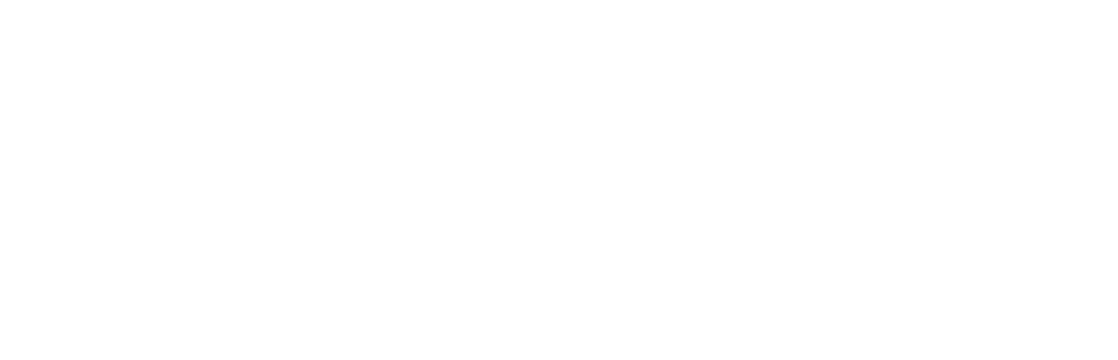

In [4]:
fig_energy = go.Figure(data=[go.Scatter3d(
    x=df['concurrency'],
    y=df['parallelism'],
    z=df['energy'],
    mode='markers',
    marker=dict(size=8, color=df['energy'], colorscale='Viridis', opacity=0.8)
)])

fig_energy.update_layout(scene=dict(
                    xaxis_title='Concurrency',
                    yaxis_title='Parallelism',
                    zaxis_title='Energy (Joules)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
                  )
pyo.iplot(fig_energy)


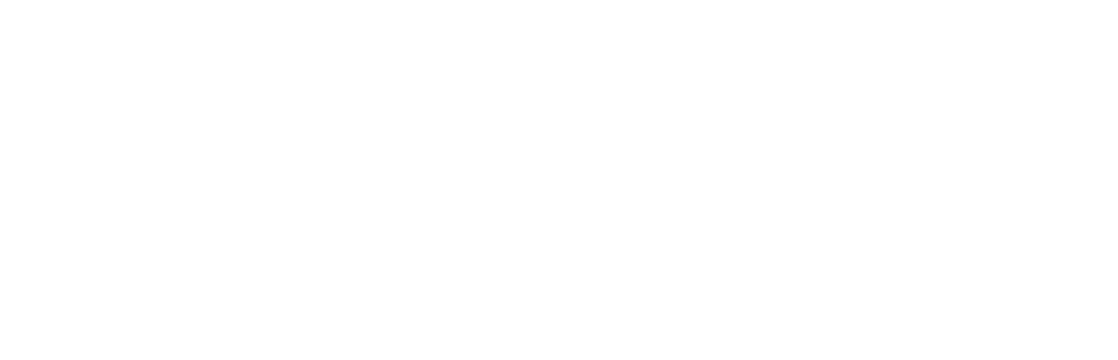

In [5]:
# 3D Plot for Throughput
fig_throughput = go.Figure(data=[go.Scatter3d(
    x=df['concurrency'],
    y=df['parallelism'],
    z=df['throughput'],
    mode='markers',
    marker=dict(size=8, color=df['throughput'], colorscale='Viridis', opacity=0.8)
)])

fig_throughput.update_layout(scene=dict(
                    xaxis_title='Concurrency',
                    yaxis_title='Parallelism',
                    zaxis_title='Throughput (mbps)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
                  )
fig_throughput.show()